# ChordShift

**Project Title**: <span style="color: red">ChordShift 1.0.0</span>

**Project Member(s)**: <span style="color: red">Anthony Avila</span>

## Introduction

I wanted to create a tool that musicians and composers could use, both for brainstorming and expanding their musical vocabulary. Having spent several years of my life studying and performing jazz as a guitarist, I often felt that the analogy of music being akin to language rang most true in the field I studied. Due to its extemporaneous nature, in which musicians improvise over a skeletal song form -- often originating from the Great American Songbook -- jazz is not only a form of self-expression (like language or any other genre of music), but it also begins to feel like you are speaking "off the dome," similar to how we conversate. Like language, a musician learns musical language much the way a child learns to speak, through input learning. Rather than mechanically memorizing musical passages and structure (a practice which does have its place in the regimen of a professional), a musician primarily absorbs ideas from their peers, and the records they listen to -- both actively and passively. Musical input learning has the advantage of creating "fluent" musicians who can easily play together in a professional setting or appeal to common conventions or sensibilities in their audiences. However, it is not without its downsides. Music theory -- and jazz theory in particular -- has continually generalized to the point that the structures a novice musician learns imply much larger combinatorial spaces of possible choices that do not occur in pre-existing recordings or among the vernacular of one's peers. If one primarily strives to learn through cultural input, they are better guaranteed a commercially viable career with a more palatable sensibility to potential listeners, with the potential downside of inadvertently restricting their palette. I struggled as a musician to become a fluent improviser because I was often not stimulated by most available recordings, and the time I spent hand-tracing new combinatorial ideas (as a much less mathematically literate person than I am now) made me rustier on gigs and less fufilled overall, not to mention that one barely explores much of harmonic combinatorial space by hand.

While the prosepect of building machine-learning-driven tools that use one's broader culture as a tabula rasa for generating listenable musical ideas is something that I will pursue in the future, I am simulataneously fascinated at the idea of building tools to explore the expansive combinatorial spaces of discrete musical structures, like notes, rhythms, harmony, and song form, in a way that has less guardrails than one would find in a probabalistic, data-driven approach.

For my first project in this field of study, I wanted to to focus of harmony. More specifically, I wanted to focus on unique combinations of notes, rather than permutations. This distinction is important, and will inform future combinatorial music projects that I'll build in the future. By focusing on unique combinations of notes for ChordShift, I am narrowing my exploration to musical structures known as pitch-class sets, which can be represented as unique subsets of the integers mod 12, modelling our 12-tone equal temperament system that most modern western music is tuned in. By narrowing my focus to pitch-class sets, I am asking myself, "what unique notes are going to be in my chords?" The broader (and equally important) question of how to arrange these notes in a musically meaningful way will be left for me to pursue with a follow-up tool focusing on chord inversions and voicings.

The following project highlights how the A* global search algorithm performs in contrast with the Simulated Annealing local search algorithm. Heuristic construction has been one of the most interesting aspects of this course, and annealing models of the nervous system were an early inspiration for me to attend college in the first place. Both algorithms utilize a simple heuristic/evaluation function that has actually allowed both algorithms to perform pretty well.

In the program, there exists a collection of example 3-chord chord progressions that can be evaluated by a dissonance metric that is informed by the user's preferences in their perception of harmonic intervals' consonance or dissonance. The program is agnostic in what it considers to be consonant or dissonant; how one chooses to rank intervals by perceived dissonance is up to the discretion of the user. The program should work the same whether you have very particular perceptions of musical intervals, perceive intervals as being generally similar, or if you just want to make noisy discordant music that preferences historically tense intervals like tritones and half-steps (minor 2nds). Each example progression produces a list of dissonances (chord dissonances and their transitions' dissonances). The pathfinding algorithm begins with this constraint as its target with the intermediate chord being replaced by a semi-random one. A* and Simulated Annealing then search for a new chord that satisfies the same levels of dissonance, with equal importance being given to the intermediate chord's dissonance contraint and its relationship to the first and last chord being captured in transition dissonances that must reach the goal state's level as well. 

The motivation behind building a tool like this is to help musicians brainstorm and "re-roll the dice" to find new musical ideas that can share some similarity with the conventions that they're used to, and if the output sounds good, they are free to assimilate it into their personal musicianship just like any other fragment of musical language that they would have found in the ever-growing corpus of music recordings, with the added benefit of being sampled from a larger wellspring of possibility.


## Imports

In [1]:
import sys
import subprocess

required_packages = [
    "numpy",
    "scipy",
    "matplotlib",
    "IPython",
    "ipywidgets"
]

def install_packages(packages):
    for package in packages:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

install_packages(required_packages)

In [2]:
import random # used for random generation of chord types and exploring random actions in Simulated Annealing
import math   # provides mathemtical functions like exponentiation or logarithms for Simulated Annealing
import heapq  # implements a priority queue for managing A*'s frontier
import time   # measures execution time of algorithms
import numpy as np  # generates simple waveforms for audio playback
from scipy.io.wavfile import write  # writes audio data to wav files for solution state playback
from IPython.display import Audio, display  # embeds and plays audio files in this notebook
import os  # manages file paths and checks the existence of files during playback and conversion
import matplotlib.pyplot as plt  # used for plotting average execution time of algorithms
import ipywidgets as widgets # used for basic UI

## AI Agent

This AI agent has versions of A* and Simulated Annealing that can be invoked to solve the search problem of finding a chord progression that matches a target dissonance. 

### Heurisitc: Minimum Edit Distance

The heuristic employed in this agent is used for both algorithms, and it calculates the minimum number of actions needed to transform the current state into the goal state. This heuristic is __admissible__ since the minimum number of actions needed to reach the goal is never greater than the actual path cost. The heuristic is __consistent__ since it never produces values that move the current state further from the target state.

### A*

This deterministic algorithm explores the most promising states first in its search for a solution. It determines what is considered "promising" by assigning a priority to each state reached that is the sum of its path cost and it's heuristic. While the provided heuristic can always be improved, a benefit of A* is that once admissibility and consistency in a heuristic is met, paths discovered are cost-optimal.

### Simulated Annealing

This non-deterministic algorithm initially explores a wide variety of states while gradually narrowing its search until it's "temperature" has cooled. Once cooled, the algorithm only explores a small amount of promising states where a solution could be found. Given how expansive the combination space is for discrete musical structures like pitch-class sets, it makes sense to use algorithms that do not need to search globally, and that have the capacity to tolerate sub-optimal states if it means reaping larger rewards in future ones.

### Assumptions

1. Actions are deterministic.
2. The heuristic is relevant and meaningful to the problem domain.
3. The state space is finite.
4. Goal candidates are pre-computed to find target states.

In [3]:
class Node:
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.__dict__.update(state=state, parent=parent, action=action, path_cost=path_cost)
        
    def __lt__(self, other):
        return self.path_cost < other.path_cost
    
    def __len__(self):
        return 0 if self.parent is None else (1 + len(self.parent))
    
class PriorityQueue:
    def __init__(self, items=(), key=lambda x : x):
        self.key = key
        self.items = []
        for item in items:
            self.add(item)
            
    def add(self, item):
        pair = (self.key(item), item)
        heapq.heappush(self.items, pair)
    
    def pop(self):
        return heapq.heappop(self.items)[1]
    
    def is_empty(self):
        return len(self.items) == 0

def heuristic_min_edit_distance(state, goal_candidates):
    state_set = set(state)
    min_edit_distance = math.inf
    
    for candidate in goal_candidates:
        candidate_set = set(candidate)
        diff = (len(state_set - candidate_set) + len(candidate_set - state_set))
        if diff < min_edit_distance:
            min_edit_distance = diff
    return min_edit_distance

# ==========================================================================================
# A*
# ==========================================================================================

failure = Node('failure', path_cost=math.inf)
nodes_expanded = 0

def expand(problem, node):
    global nodes_expanded
    nodes_expanded += 1
    
    s = node.state
    for act in problem.actions(s):
        s1 = problem.result(s, act)
        cost = node.path_cost + problem.action_cost(s, act, s1)
        yield Node(s1, node, act, cost)
        
def Best_First_Search(problem, f):
    node = Node(state=problem.initial)
    frontier = PriorityQueue(items=[node], key=f)
    reached = {problem.initial: node}
    
    while not frontier.is_empty():
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
    
    return failure

def AStar(problem, h):
    def a_star_calculate(n):
        return h(n) + n.path_cost
    return Best_First_Search(problem, a_star_calculate)
    
# ==========================================================================================
# Simulated Annealing
# ==========================================================================================

def schedule(t):
    k = 10
    r = 0.75
    return k * math.exp(-r * t)
        
def SimulatedAnnealing(problem, schedule, sample_interval=1000):
    current = Node(problem.initial)
    t = 1
    sampled_states = [(t, current.state)]
    
    while True:
        T = schedule(t)
        if T == 0 or problem.is_goal(current.state):
            return current, sampled_states, t
    
        acts = list(problem.actions(current.state))
        action = random.choice(acts)
        s1 = problem.result(current.state, action)
        child = Node(s1,
                     parent=current,
                     action=action,
                     path_cost=current.path_cost + problem.action_cost(current.state, action, s1))
    
        current_value = problem.h(current)
        next_value = problem.h(child)
        dE = current_value - next_value
    
        if dE > 0 or random.random() < math.exp(dE / T):
            current = child
    
        if t % sample_interval == 0:
            sampled_states.append((t, current.state))
            
        t += 1


## Problem

### PEAS Model Description:

- The __performance measure__ is whether a solution with target dissonances is found.
- The __environment__ is __fully observable__ (the chord progression at any state is known), __deterministic__ (all actions are known for any state), __static__ (the environment does not change while the agent is searching), __discrete__ (due to the nature of the integers mod 12), and __single-agent__.
- The __actuators__ are the following: add any single note that isn't already in the pitch-class set, or remove any single note that is already in the pitch-class set.
- The __sensors__ are the dissonance metrics and the `is_goal_state()` function.


In [4]:
class Problem:
    def __init__(self, initial=None, goal=None, **kwds):
        self.__dict__.update(initial=initial, goal=goal, **kwds)
        
    def actions(self, state):
        raise NotImplementedError
        
    def result(self, state, action):
        raise NotImplementedError
        
    def is_goal(self, state):
        return state == self.goal
    
    def action_cost(self, s, a , s1):
        return 1

def is_goal_state(state, ctype1, ctype3, target_disso):
    disso_ctype1 = calc_disso_ctype(ctype1)
    disso_trans1 = calc_disso_transition(ctype1, state)
    disso_ctype2 = calc_disso_ctype(state)
    disso_trans2 = calc_disso_transition(state, ctype3)
    disso_ctype3 = calc_disso_ctype(ctype3)
    
    return (disso_ctype1 == target_dissos[0] and
            disso_trans1 == target_dissos[1] and
            disso_ctype2 == target_dissos[2] and
            disso_trans2 == target_dissos[3] and
            disso_ctype3 == target_dissos[4])
    
class ChordShift(Problem):
    def __init__(self, ctype1, ctype3, target_dissos, initial, goal_candidates=None):
        super().__init__(initial=initial, goal=None)
        self.ctype1 = tuple(sorted(ctype1))
        self.ctype3 = tuple(sorted(ctype3))
        self.target_dissos = target_dissos
        self.goal_candidates = goal_candidates if goal_candidates else []
        
    def actions(self, state):
        # we don't need an action explicitly, result() can infer it
        return range(12)
    
    def result(self, state, action):
        state_set = set(state)
        if action in state_set:
            if len(state_set) > 1:
                state_set.remove(action)
        else:
            state_set.add(action)
        return tuple(sorted(state_set))
    
    def is_goal(self, state):
        return is_goal_state(state, self.ctype1, self.ctype3, self.target_dissos)
    
    def action_cost(self, s, a, s1):
        return 1
    
    def h (self, node):
        return heuristic_min_edit_distance(node.state, self.goal_candidates)

## Results and Analysis

Because the algorithms are so different, the only metric that made sense to compare them by was simply their execution time. Originally, A* was performing well as expected, with Simulated Annealing producing very sub-optimal results. My intuition was that the heuristic I devised for A* was simply not a "one-size-fits-all" evaluation function that translated well to Simulated Annealing; perhaps in the future I would have to develop a more sophisticated probabilistic or data-driven evaluation function. However, upon switching the signs of the evaluation function for Simuated Annealing late at night, it magically began working much better. So well in fact, that on average and in a best-case scenario, Simulated Annealing peformed better. When flipping the signs of an evaluation function, you are effectively changing the direction of the gradient. It is absolutely necessary to try both directions before assuming a larger structural failure is at play, like a flaw in the heuristic. In this case, "lower was better".

In [5]:
# ==========================================================================================
# Global Variables
# ==========================================================================================

dissonance_ratings = {
    # my subjective rating of intervals by their perceived dissonance
    'default': {
        0: 0,        # UU
        1: 4,        # m2
        2: 2,        # M2
        3: 2,        # m3
        4: 2,        # M3
        5: 1,        # P4
        6: 4,        # TT
        7: 1,        # P5
        8: 3,        # m6
        9: 2,        # M6
        10: 2,       # m7
        11: 3        # M7
    },
    # intervals are more dissonant the more distant they are on the circle of fifths
    'circle_of_fifths': {
        0: 0,        # UU
        1: 5,        # m2
        2: 2,        # M2
        3: 3,        # m3
        4: 4,        # M3
        5: 1,        # P4
        6: 6,        # TT
        7: 1,        # P5
        8: 4,        # m6
        9: 3,        # M6
        10: 2,       # m7
        11: 5        # M7
    },
    # intervals are more dissonant if a larger prime number is needed to construct a just-intonation interval ratio that is within a 1% margin of error from its irrational counterpart in 12-EDO
    'custom_plimit': {
        0: 0,        # 1-limit
        1: 2,        # 5-limit
        2: 1,        # 3-limit
        3: 1,        # 3-limit
        4: 1,        # 3-limit
        5: 1,        # 3-limit
        6: 3,        # 7-limit
        7: 1,        # 3-limit
        8: 1,        # 3-limit
        9: 1,        # 3-limit
        10: 1,       # 3-limit
        11: 2        # 5-limit
    },
    # my 3-tiered subjective rating of intervals by perceived dissonance
    'lo_med_hi': {
        0: 0,        # UU
        1: 2,        # m2
        2: 1,        # M2
        3: 1,        # m3
        4: 1,        # M3
        5: 0,        # P4
        6: 2,        # TT
        7: 0,        # P5
        8: 1,        # m6
        9: 1,        # M6
        10: 1,       # m7
        11: 2        # M7
    },
    # my 12-tiered subjective rating of intervals by perceived dissonance
    'each_unique': {
        0: 0,        # UU
        1: 10,       # m2
        2: 3,        # M2
        3: 7,        # m3
        4: 4,        # M3
        5: 2,        # P4
        6: 11,       # TT
        7: 1,        # P5
        8: 8,        # m6
        9: 5,        # M6
        10: 6,       # m7
        11: 9        # M7
    },
    # the opposite rating than how I would subjectively rank intervals by dissonance
    'ohio': {
        0: 4,        # UU
        1: 0,        # m2
        2: 2,        # M2
        3: 2,        # m3
        4: 2,        # M3
        5: 3,        # P4
        6: 0,        # TT
        7: 3,        # P5
        8: 1,        # m6
        9: 2,        # M6
        10: 2,       # m7
        11: 1        # M7
    }
}

test_progressions = {
    'ii V I simple' : [
        [2,5,9],
        [5,7,11],
        [0,4,7]
    ],
    'ii V I' : [
        [2,5,9],
        [2,5,7,11],
        [0,4,7]
    ],
    'ii V I 7ths' : [
        [0,2,5,9],
        [2,5,7,11],
        [0,4,7,11]
    ],
    'ii V I 9ths' : [
        [0,2,4,5,9],
        [2,5,7,9,11],
        [0,2,4,7,11]
    ],
    'giant steps tonal centers' : [
        [0,4,7,11],
        [3,4,8,11], 
        [0,3,7,8]
    ],
    'deep house 1' : [
        [0,3,5,7,8,10],
        [0,2,3,5,7,10],
        [0,2,4,5,7,9] 
    ],
    'deep house 2' : [
        [2,5,7,9,10],
        [0,2,3,7,10],
        [3,6,8,10,11]
    ],
    'deep house 3' : [
        [2,5,9,10],
        [0,1,3,5,8],
        [1,3,6,8,10]
    ]
}

# ==========================================================================================
# Dissonance Calculation
# ==========================================================================================

MOST_DISSONANT = [0,1,2,3,4,5,6,7,8,9,10,11]	
LEAST_DISSONANT = [0]

def interval(note1, note2):
    return abs(note2 - note1) % 12

def calc_disso_interval(interval):
    return dissonance_score.get(interval)

def calc_disso_ctype(ctype):
    if len(ctype) == 1:
        return (0, 1)
    interval_scores = []
    for i, note1 in enumerate(ctype):
        for j, note2 in enumerate(ctype):
            if i < j:
                interval_ = interval(note1, note2)
                score = calc_disso_interval(interval_)
                interval_scores.append(score)
    highest_disso_score = max(interval_scores)
    frequency = interval_scores.count(highest_disso_score)
    return (highest_disso_score, frequency)

def ctype_union(ctype1, ctype2):
    ctype1_set = set([note % 12 for note in ctype1])
    ctype2_set = set([note % 12 for note in ctype2])
    union = ctype1_set | ctype2_set
    return sorted(union)

def calc_disso_transition(ctype1, ctype2):
    return calc_disso_ctype(ctype_union(ctype1, ctype2))

# ==========================================================================================
# Brute Force Pre-Computation Helpers
# ==========================================================================================

def generate_random_ctype(ctype_size):
    ctype = random.sample(range(12), ctype_size)
    ctype.sort()
    return ctype

def find_ctype_with_disso(target_disso, max_attempts=100000):
    attempt_count = 0
    
    while attempt_count < max_attempts:
        ctype = generate_random_ctype(random.randint(1,12))
        y_tuple = calc_disso_ctype(ctype)
        if y_tuple == target_disso:
            return ctype
        attempt_count += 1
        
    return None

def find_goal_candidates(target_dissos, ctype1, ctype3, max_tries=10000):
    valid_intermediate_chords = set()
    intermediate_disso = target_dissos[2]
    
    for attempt in range(max_tries):
        ctype2 = find_ctype_with_disso(intermediate_disso, 100000)
        ctype2 = sorted(ctype2)
        
        disso_ctype1 = calc_disso_ctype(ctype1)
        disso_trans1 = calc_disso_transition(ctype1, ctype2)
        disso_ctype2 = calc_disso_ctype(ctype2)
        disso_trans2 = calc_disso_transition(ctype2, ctype3)
        disso_ctype3 = calc_disso_ctype(ctype3)
        
        if (disso_ctype1 == target_dissos[0] and
            disso_trans1 == target_dissos[1] and
            disso_ctype2 == target_dissos[2] and
            disso_trans2 == target_dissos[3] and
            disso_ctype3 == target_dissos[4]):
            # all dissonances match target
            valid_intermediate_chords.add(tuple(ctype2))
    
    return valid_intermediate_chords

def verify_goal_candidates_exist(valid_intermediate_chords):
    if len(valid_intermediate_chords) == 0:
            print("No valid intermediate chords found.")
    else:
        print(f"Found {len(valid_intermediate_chords)} solutions (valid intermediate chords) with brute force:\n")
        for chord in valid_intermediate_chords:
            print(f"\t{list(chord)}")
    print()

# ==========================================================================================
# Audio Playback and UI
# ==========================================================================================

def generate_sine_wave(frequency, duration, sample_rate=44100, amplitude=0.5):
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    wave = amplitude * np.sin(2 * np.pi * frequency * t)
    return wave

def chords_to_sine_wave(chords, filename="chords.wav", duration=1, sample_rate=44100):
    waves = []
    for chord in chords:
        chord_wave = np.zeros(int(sample_rate * duration))
        for note in chord:
            frequency = 440.0 * (2 ** ((note - 69) / 12.0))
            chord_wave += generate_sine_wave(frequency, duration, sample_rate)
        waves.append(chord_wave)
    full_wave = np.concatenate(waves)
    full_wave = np.int16(full_wave / np.max(np.abs(full_wave)) * 32767)
    write(filename, sample_rate, full_wave)
    return Audio(filename, autoplay=False)

# ==========================================================================================
# Results
# ==========================================================================================

def initialize(dissonance_rating='circle_of_fifths', progression='ii V I'):
    global dissonance_score
    dissonance_score = dissonance_ratings.get(dissonance_rating, dissonance_ratings['default'])
    
    chords = test_progressions.get(progression)
    ctype1 = chords[0]
    ctype2 = chords[1]
    ctype3 = chords[2]

    chord1_disso = calc_disso_ctype(ctype1)
    transition1_disso = calc_disso_transition(ctype1, ctype2)
    chord2_disso = calc_disso_ctype(ctype2)
    transition2_disso = calc_disso_transition(ctype2, ctype3)
    chord3_disso = calc_disso_ctype(ctype3)
    
    target_dissos = [
        chord1_disso,
        transition1_disso,
        chord2_disso,
        transition2_disso,
        chord3_disso
    ]
    
    return dissonance_score, ctype1, ctype2, ctype3, target_dissos

ratings = list(dissonance_ratings.keys())
progressions = list(test_progressions.keys())
ratings_dropdown = widgets.Dropdown(
    options=ratings,
    description='Ratings:',
    value=ratings[1],
    layout=widgets.Layout(width='1000px', height='50px'),
    style={'description_width': '100px'},
)
progressions_dropdown = widgets.Dropdown(
    options=progressions,
    description='Progressions:',
    value=progressions[2],
    layout=widgets.Layout(width='1000px', height='50px'),
    style={'description_width': '100px'},
)
display(ratings_dropdown, progressions_dropdown)


Dropdown(description='Ratings:', index=1, layout=Layout(height='50px', width='1000px'), options=('default', 'c…

Dropdown(description='Progressions:', index=2, layout=Layout(height='50px', width='1000px'), options=('ii V I …


Original Progression:


Target Dissonances (solution states must have these corresponding dissonance values):
	Chord 1      : (4, 1)
	Transition 1 : (6, 1)
	Chord 2      : (6, 1)
	Transition 2 : (6, 1)
	Chord 3      : (5, 1)


Found 112 solutions (valid intermediate chords) with brute force:

	[0, 4, 7, 10]
	[0, 2, 3, 7, 9]
	[0, 2, 5, 7, 11]
	[0, 2, 4, 6]
	[0, 1, 4, 7]
	[0, 5, 7, 11]
	[0, 1, 7, 9]
	[0, 1, 2, 4, 7]
	[0, 2, 4, 8]
	[0, 5, 9, 11]
	[0, 2, 6]
	[2, 3, 7, 9]
	[2, 5, 7, 11]
	[0, 4, 5, 7, 9, 11]
	[0, 2, 3, 9]
	[2, 5, 11]
	[2, 7, 8]
	[2, 5, 9, 11]
	[2, 4, 5, 9, 11]
	[4, 7, 10]
	[0, 2, 4, 5, 7, 9, 11]
	[0, 2, 4, 10]
	[0, 2, 6, 7]
	[2, 4, 5, 11]
	[0, 2, 8]
	[0, 1, 2, 4, 7, 9]
	[0, 2, 4, 5, 9, 11]
	[2, 8, 9]
	[2, 7, 8, 9]
	[4, 9, 10]
	[0, 2, 4, 5, 11]
	[0, 2, 5, 11]
	[0, 2, 7, 8]
	[0, 1, 2, 7]
	[0, 2, 5, 9, 11]
	[2, 4, 9, 10]
	[0, 4, 5, 11]
	[1, 4, 7]
	[0, 1, 2, 7, 9]
	[3, 4, 9]
	[5, 7, 11]
	[0, 4, 6]
	[2, 4, 7, 8, 9]
	[5, 11]
	[5, 9, 11]
	[1, 2, 4, 7, 9]
	[1, 2, 4, 7]
	[4, 7, 9, 10]
	[0, 4, 5, 9, 11]
	[1,


A* Results:
	Execution Time: 1.23 ms
	Nodes Expanded: 1
	Solution Path Length: 1
	Solution Path:
		Initial State:
			[0, 2, 5, 9]
			[2, 3, 4, 5, 11]
			[0, 4, 7, 11]
		Solution State:
			[0, 2, 5, 9]
			[2, 4, 5, 11]
			[0, 4, 7, 11]
	Initial State Dissonances:
		[0, 2, 5, 9]                                       : (4, 1)
		[0, 2, 5, 9]->[2, 3, 4, 5, 11]                     : (6, 2)
		[2, 3, 4, 5, 11]                                   : (6, 1)
		[2, 3, 4, 5, 11]->[0, 4, 7, 11]                    : (6, 1)
		[0, 4, 7, 11]                                      : (5, 1)
	Solution State Dissonances:
		[0, 2, 5, 9]                                       : (4, 1)
		[0, 2, 5, 9]->[2, 4, 5, 11]                        : (6, 1)
		[2, 4, 5, 11]                                      : (6, 1)
		[2, 4, 5, 11]->[0, 4, 7, 11]                       : (6, 1)
		[0, 4, 7, 11]                                      : (5, 1)

A* Solution:



Simulated Annealing Results:
	Execution Time: 0.99 ms
	Total Iterations: 4
	Sampled States:
		Initial State:
			[0, 2, 5, 9]
			[2, 3, 4, 5, 11]
			[0, 4, 7, 11]
		Solution State:
			[0, 2, 5, 9]
			[2, 3, 4, 9]
			[0, 4, 7, 11]
	Initial State Dissonances:
		[0, 2, 5, 9]                                       : (4, 1)
		[0, 2, 5, 9]->[2, 3, 4, 5, 11]                     : (6, 2)
		[2, 3, 4, 5, 11]                                   : (6, 1)
		[2, 3, 4, 5, 11]->[0, 4, 7, 11]                    : (6, 1)
		[0, 4, 7, 11]                                      : (5, 1)
	Solution State Dissonances:
		[0, 2, 5, 9]                                       : (4, 1)
		[0, 2, 5, 9]->[2, 3, 4, 9]                         : (6, 1)
		[2, 3, 4, 9]                                       : (6, 1)
		[2, 3, 4, 9]->[0, 4, 7, 11]                        : (6, 1)
		[0, 4, 7, 11]                                      : (5, 1)


Simulated Annealing Solution:


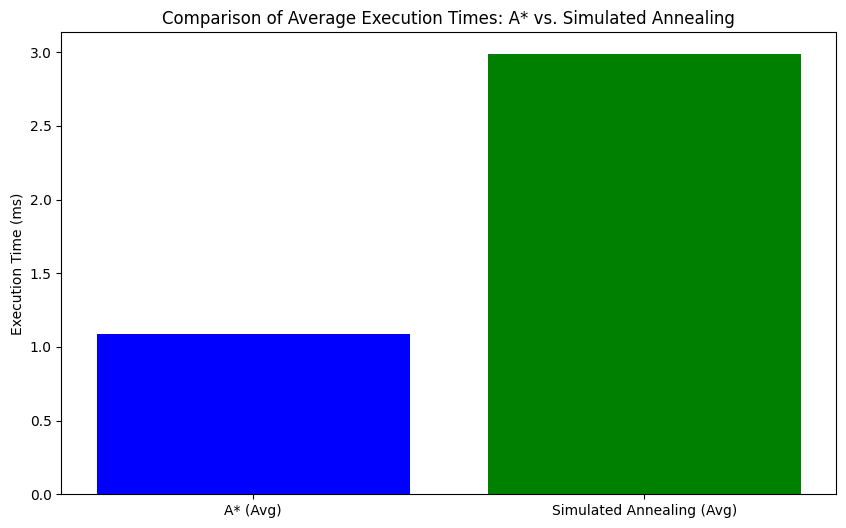

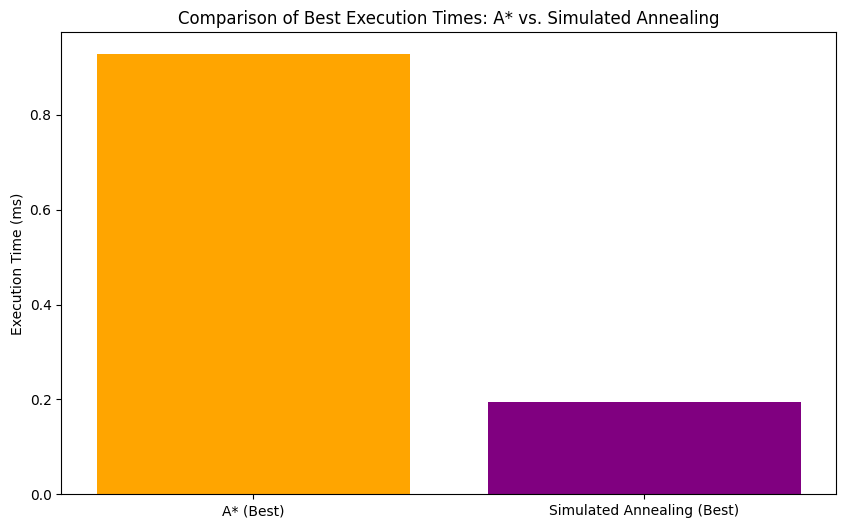

In [6]:
selected_rating = ratings_dropdown.value
selected_progression = progressions_dropdown.value

# Beginning the program
dissonance_score, ctype1, ctype2, ctype3, target_dissos = initialize(dissonance_rating=selected_rating, progression=selected_progression)

print("\nOriginal Progression:")
# Let 0 == C3
chords_to_play = [
    [note + 60 for note in ctype1],
    [note + 60 for note in ctype2],
    [note + 60 for note in ctype3]
]
sine_wave_audio = chords_to_sine_wave(chords_to_play, filename="original_progression.wav")
display(sine_wave_audio)

# ==========================================================================================
# Stating the Target
# ==========================================================================================
    
print("Target Dissonances (solution states must have these corresponding dissonance values):")
print(f"\tChord 1      : {target_dissos[0]}")
print(f"\tTransition 1 : {target_dissos[1]}")
print(f"\tChord 2      : {target_dissos[2]}")
print(f"\tTransition 2 : {target_dissos[3]}")
print(f"\tChord 3      : {target_dissos[4]}")
print()


# ==========================================================================================
# Setting Up the Problem and Verifying Solutions Exist With Brute Force
# ==========================================================================================
    
print("=" * 90)
start_ctype2 = tuple(sorted(find_ctype_with_disso(target_dissos[2], max_attempts=100000)))

brute_start_time = time.time()
goal_candidates = find_goal_candidates(target_dissos, ctype1, ctype3, max_tries=10000)
brute_end_time = time.time()
brute_force_time = (brute_end_time - brute_start_time) * 1000
print()
verify_goal_candidates_exist(goal_candidates)
print(f"Execution Time: {brute_force_time:.2f} ms")
print()
problem = ChordShift(
                ctype1, 
                ctype3, 
                target_dissos, 
                initial=start_ctype2, 
                goal_candidates=goal_candidates
)

print("=" * 90)
print("\nInitial State:")
# Let 0 == C3
chords_to_play = [
    [note + 60 for note in ctype1],
    [note + 60 for note in start_ctype2],
    [note + 60 for note in ctype3]
]
sine_wave_audio = chords_to_sine_wave(chords_to_play, filename="initial_state.wav")
display(sine_wave_audio)

# ==========================================================================================
# A*
# ==========================================================================================
    
as_start_time = time.time()
solution = AStar(problem, problem.h)
as_end_time = time.time()
a_star_time = (as_end_time - as_start_time) * 1000
    
print("=" * 90)
print("\nA* Results:")
print(f"\tExecution Time: {a_star_time:.2f} ms")
print(f"\tNodes Expanded: {nodes_expanded}")
if solution.state == 'failure':
    print("No solution found.")
else:
    path = []
    node = solution
    while node:
        path.append(node.state)
        node = node.parent
    path.reverse()
    print(f"\tSolution Path Length: {solution.path_cost}")
    print("\tSolution Path:")
    if solution.path_cost == 0:
        print(f"\t\tInitial and Solution State:\n\t\t\t{ctype1}\n\t\t\t{list(start_ctype2)}\n\t\t\t{ctype3}")
    elif solution.path_cost == 1:
        print(f"\t\tInitial State:\n\t\t\t{ctype1}\n\t\t\t{list(start_ctype2)}\n\t\t\t{ctype3}")
        print(f"\t\tSolution State:\n\t\t\t{ctype1}\n\t\t\t{list(path[-1])}\n\t\t\t{ctype3}")
    else:
        print(f"\t\tInitial State:\n\t\t\t{ctype1}\n\t\t\t{list(start_ctype2)}\n\t\t\t{ctype3}")
        for i, p in enumerate(path[:-1], start=2):
            print(f"\t\tState {i}:\n\t\t\t{ctype1}\n\t\t\t{list(p)}\n\t\t\t{ctype3}")
        print(f"\t\tSolution State:\n\t\t\t{ctype1}\n\t\t\t{list(path[-1])}\n\t\t\t{ctype3}")
            
    print(f"\tInitial State Dissonances:")
    print(f"\t\t{str(ctype1):<50} : {calc_disso_ctype(ctype1)}")
    print(f"\t\t{str(ctype1) + '->' + str(list(start_ctype2)):<50} : {calc_disso_transition(ctype1, start_ctype2)}")
    print(f"\t\t{str(list(start_ctype2)):<50} : {calc_disso_ctype(start_ctype2)}")
    print(f"\t\t{str(list(start_ctype2)) + '->' + str(ctype3):<50} : {calc_disso_transition(start_ctype2, ctype3)}")
    print(f"\t\t{str(ctype3):<50} : {calc_disso_ctype(ctype3)}")
        
    print(f"\tSolution State Dissonances:")
    print(f"\t\t{str(list(ctype1)):<50} : {calc_disso_ctype(ctype1)}")
    print(f"\t\t{str(list(ctype1)) + '->' + str(list(path[-1])):<50} : {calc_disso_transition(ctype1, path[-1])}")
    print(f"\t\t{str(list(path[-1])):<50} : {calc_disso_ctype(path[-1])}")
    print(f"\t\t{str(list(path[-1])) + '->' + str(list(ctype3)):<50} : {calc_disso_transition(path[-1], ctype3)}")
    print(f"\t\t{str(list(ctype3)):<50} : {calc_disso_ctype(ctype3)}")
print()

# A* Solution Playback
if solution.state != 'failure':
    print("A* Solution:")
    # Let 0 == C3
    chords_to_play = [
        [note + 60 for note in ctype1],
        [note + 60 for note in path[-1]],
        [note + 60 for note in ctype3]
    ]
    sine_wave_audio = chords_to_sine_wave(chords_to_play, filename="a_star_solution.wav")
    display(sine_wave_audio)

# ==========================================================================================
# Simulated Annealing
# ==========================================================================================
    
sa_start_time = time.time()
solution, sampled_states, total_iterations = SimulatedAnnealing(problem, schedule, sample_interval=5)
sa_end_time = time.time()
simulated_annealing_time = (sa_end_time - sa_start_time) * 1000
    
print("=" * 90)
print("\nSimulated Annealing Results:")
print(f"\tExecution Time: {simulated_annealing_time:.2f} ms")
if solution == 'failure':
    print("No solution found.")
else:
    print(f"\tTotal Iterations: {total_iterations}")
    print("\tSampled States:")
    first_iteration, first_state = sampled_states[0]
    print(f"\t\tInitial State:\n\t\t\t{ctype1}\n\t\t\t{list(first_state)}\n\t\t\t{ctype3}")
    for iteration, state in sampled_states[1:]:
        print(f"\t\tState at Iteration {iteration}:\n\t\t\t{ctype1}\n\t\t\t{list(state)}\n\t\t\t{ctype3}")
    print(f"\t\tSolution State:\n\t\t\t{ctype1}\n\t\t\t{list(solution.state)}\n\t\t\t{ctype3}")
        
    print(f"\tInitial State Dissonances:")
    print(f"\t\t{str(ctype1):<50} : {calc_disso_ctype(ctype1)}")
    print(f"\t\t{str(ctype1) + '->' + str(list(start_ctype2)):<50} : {calc_disso_transition(ctype1, start_ctype2)}")
    print(f"\t\t{str(list(start_ctype2)):<50} : {calc_disso_ctype(start_ctype2)}")
    print(f"\t\t{str(list(start_ctype2)) + '->' + str(ctype3):<50} : {calc_disso_transition(start_ctype2, ctype3)}")
    print(f"\t\t{str(ctype3):<50} : {calc_disso_ctype(ctype3)}")
        
    print(f"\tSolution State Dissonances:")
    print(f"\t\t{str(list(ctype1)):<50} : {calc_disso_ctype(ctype1)}")
    print(f"\t\t{str(list(ctype1)) + '->' + str(list(solution.state)):<50} : {calc_disso_transition(ctype1, solution.state)}")
    print(f"\t\t{str(list(solution.state)):<50} : {calc_disso_ctype(solution.state)}")
    print(f"\t\t{str(list(solution.state)) + '->' + str(list(ctype3)):<50} : {calc_disso_transition(solution.state, ctype3)}")
    print(f"\t\t{str(list(ctype3)):<50} : {calc_disso_ctype(ctype3)}")
print()

# Simulated Annealing Solution Playback
if solution.state != 'failure':
    print("\nSimulated Annealing Solution:")
    # Let 0 == C3
    chords_to_play = [
        [note + 60 for note in ctype1],
        [note + 60 for note in solution.state],
        [note + 60 for note in ctype3]
    ]
    sine_wave_audio = chords_to_sine_wave(chords_to_play, filename="simulated_annealing_solution.wav")
    display(sine_wave_audio)
print("=" * 90)

# ==========================================================================================
# Comparison of Execution Time
# ==========================================================================================

def compare_algorithms(problem, a_star_heuristic, sa_schedule, iterations=10):
    a_star_times = []
    sa_times = []

    for _ in range(iterations):
        as_start_time = time.time()
        solution = AStar(problem, a_star_heuristic)
        as_end_time = time.time()
        a_star_times.append((as_end_time - as_start_time) * 1000)

        sa_start_time = time.time()
        solution, sampled_states, total_iterations = SimulatedAnnealing(problem, sa_schedule)
        sa_end_time = time.time()
        sa_times.append((sa_end_time - sa_start_time) * 1000)

    avg_a_star_time = sum(a_star_times) / iterations
    avg_sa_time = sum(sa_times) / iterations
    best_a_star_time = min(a_star_times)
    best_sa_time = min(sa_times)

    plt.figure(figsize=(10, 6))
    plt.bar(["A* (Avg)", "Simulated Annealing (Avg)"], [avg_a_star_time, avg_sa_time], color=['blue', 'green'])
    plt.ylabel("Execution Time (ms)")
    plt.title("Comparison of Average Execution Times: A* vs. Simulated Annealing")
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.bar(["A* (Best)", "Simulated Annealing (Best)"], [best_a_star_time, best_sa_time], color=['orange', 'purple'])
    plt.ylabel("Execution Time (ms)")
    plt.title("Comparison of Best Execution Times: A* vs. Simulated Annealing")
    plt.show()

problem = ChordShift(ctype1, ctype3, target_dissos, initial=start_ctype2, goal_candidates=goal_candidates)
a_star_heuristic = problem.h
simulated_annealing_schedule = schedule
compare_algorithms(problem, a_star_heuristic, simulated_annealing_schedule, iterations=2500)


## Conclusion

### Improving the Dissonance Metric

Currently the dissonance metric treats two pitch-class sets as equally dissonant if they both contain at least one interval of a relatively dissonant interval. Perhaps a future iteration would also take into account the frequency of less dissonant intervals, and the number of notes in the pitch-class set. These metrics could also be part of a new weighted sum heuristic.

### Search Algorithms: Optimized or Overkill?

Earlier in the program's development I had imagined the user specifying initial and terminal chords, with the user also specifying target dissonance levels. Sometimes however, this would result in targets for which there existed no solutions, and it seemed impossible to find an upper bound for dissonance levels of transitions only knowing the dissonance level of the intermediate chord and not the chord itself (eg. cmaj->cmaj has a lower upper bound of transition dissonance than cmaj->dbmaj despite these major chords all sharing the same dissonance levels). To remedy this, I began building a brute force pre-computation function that would check if solutions even existed, but this kind of defeats the purpose of searching for a solution at all! That said, this brute force function was far less efficient than A* or Simulated Annealing, but those algorithms still benefitted from the pre-computation in their own logic. Perhaps it doesn't really make a difference in a 12-note system, but as the number of notes in your tuning system increases, the number of pitch-class sets grows exponentially, and search algorithms with the help of some minimal pre-computation may always outperform brute force. I would have to run more tests to determine this in a future version.

### Heuristic Crafting

I definitely want to explore random search for hyperparameters for crafting the best heuristic. I would also like to explore crafting data-driven and probabalistic heuristics, either based on personal data entry of my favorite music, or by utilizing pre-existing datasets, and have these heuristics factor into the final heuristic. After creating a bunch of sub-heuristics, I would include them all as part of a weighted sum that would be subject to random search.

### UI and Upper Bounds of Transition Dissonance

I need to conduct more tests to determine if it is possible to know the actual transition dissonance given only chord dissonance. So far, this seems impossible, but I would love to keep working at it; it would play a huge role in the ease of "knob-turning" in the UX design.

### Looking Ahead

I loved working on this project so much that I already have future versions planned:
- __ChordShift 2.0.0__: Jupyter Notebook with more pitch-class set analysis, a more sophisticated heuristic, a variable number of intermediate chords and tuning system note count, and the option for the user to manually input a target state or load in their custom MIDI chord progressions in a basic UI.
- __ChordShift 3.0.0__: MaxMSP prototype to focus on UI and UX Design.
- __ChordShift 4.0.0__: Complete VST Plugin in C++ using the JUCE framework

I also had ideas for other projects related to pitch-class sets:
- __InversionShift 1.0.0__: designed to follow after ChordShift in a Digital Audio Workstation's (DAW) track signal chain; reorders the output of ChordShift into meaningful inversions and voicings.
- NLP-inspired n-grams to find common syntactical movements in MIDI datasets using a pitch-class set model.
- Psychopsychics project where random chord progressions from random dissonance rankings are shown to participants. User ratings are given until a general ranking of intervals by dissonance is discovered.
- Working with pitch-class sets and other discrete musical structures in the context of Discrete Fourier Transform for musical waves other than sound (eg. melodic contour).